## Домашнее задание "Сегментация и детекция объектов"
Распознавание рукописного ввода на примере базы MNIST

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.

Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.

В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.
https://www.kaggle.com/c/digit-recognizer

In [2]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Загружаем исходные данные

In [3]:
train = np.loadtxt('./data/digit/train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('./data/digit/test.csv', delimiter=',', skiprows=1)

In [8]:
print(train.shape)
print(test.shape)

(42000, 785)
(28000, 784)


In [6]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]
# приводим размерность к удобному для обработки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

In [9]:
print(train_img.shape)
print(train_label.shape)
print(test_img.shape)

(42000, 28, 28)
(42000,)
(28000, 28, 28)


## Визуализируем исходные данные

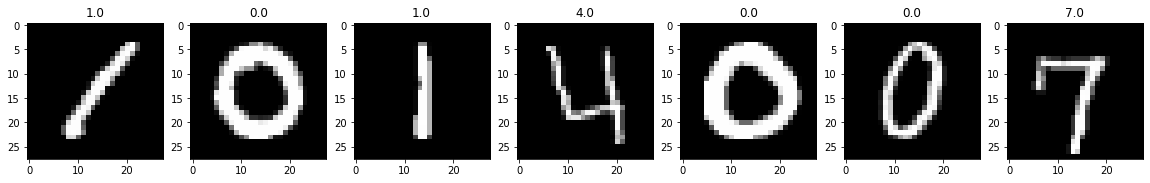

In [10]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [15]:
# вычисление градиента для тренировочной выборки
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [13]:
# вычисление градиента для тестовой выборки
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [16]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [17]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

## Визуализируем гистрограмму градиентов

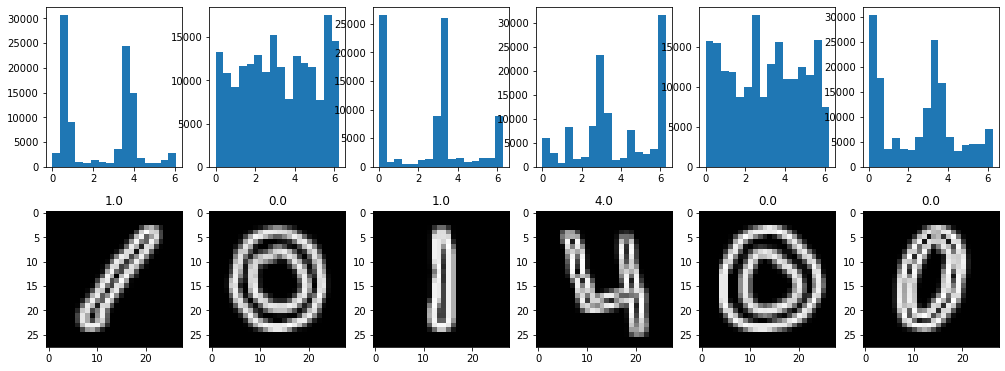

In [18]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:6], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [19]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [20]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Нормируем вектор гистограммы

In [22]:
# По умолчанию используется L2 норма
train_hist = train_hist / np.linalg.norm(train_hist, axis=1)[:, None]

In [23]:
test_hist = test_hist / np.linalg.norm(test_hist, axis=1)[:, None]

## PCA - преобразование

## центрируем данные

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# обучаем StandardScaler() на тренировочных данных, и затем трансформируем данные
train_scaled = scaler.fit_transform(train_img.reshape(-1, 28 * 28).astype(np.float32))
print(train_scaled.shape)

(42000, 784)


## делаем PCA - преобразование над центрированными данными

In [37]:
from sklearn.decomposition import PCA
pca = PCA(0.5)
# PCA также обучаем на тренировочных данных
train_reduced = pca.fit_transform(train_scaled)
train_reduced.shape

(42000, 38)

In [38]:
# трансформируем тестовые данные 
test_scaled = scaler.transform(test_img.reshape(-1, 28 * 28).astype(np.float32))
test_reduced = pca.transform(test_scaled)

## конкатенируем вектора гистограммы градиентов и PCA-вектора

In [39]:
train_hist.shape

(42000, 16)

In [41]:
train_stacked = np.hstack([train_hist, train_reduced])
print(train_stacked.shape)

(42000, 54)


### Итого 16 признаков гистограммы градиентов и 38 признаков РСА-преобразования, в сумме 54 признака

## Разбиваем выборку на обучение и валидацию

In [42]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(train_label, train_stacked, test_size=0.2, random_state=42)

In [45]:
from sklearn.linear_model import LogisticRegression

In [46]:
model = LogisticRegression(random_state=0, solver='liblinear')
model.fit(x_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [47]:
y_pred = model.predict(x_val)
y_pred

array([8., 1., 9., ..., 3., 0., 9.])

## Оцениваем качество на валидационной выборке

In [49]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred))

Accuracy: 0.93


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       816
         1.0       0.96      0.99      0.98       909
         2.0       0.92      0.90      0.91       846
         3.0       0.93      0.91      0.92       937
         4.0       0.94      0.93      0.94       839
         5.0       0.90      0.92      0.91       702
         6.0       0.94      0.95      0.95       785
         7.0       0.94      0.91      0.92       893
         8.0       0.90      0.92      0.91       835
         9.0       0.89      0.89      0.89       838

    accuracy                           0.93      8400
   macro avg       0.93      0.93      0.93      8400
weighted avg       0.93      0.93      0.93      8400



In [51]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[799   0   1   0   1   5   5   1   3   1]
 [  1 898   2   0   1   1   2   0   4   0]
 [  4   7 758  17   9   8   8  10  21   4]
 [  1   0  15 852   0  26   2   6  19  16]
 [  1   4   5   0 782   0  13   2   4  28]
 [  1   1   7  21   2 643  14   0  10   3]
 [  9   2   6   1   6   4 749   1   6   1]
 [  1   5  18   5   5   8   0 814   5  32]
 [  5   6   6   9   5  14   6   4 768  12]
 [  3   8   3  11  20   4   0  30  10 749]]


## Предсказания на тестовыйх данных

In [52]:
test_stacked = np.hstack([test_hist, test_reduced])
pred_test = model.predict(test_stacked)

## Визуализируем предсказания

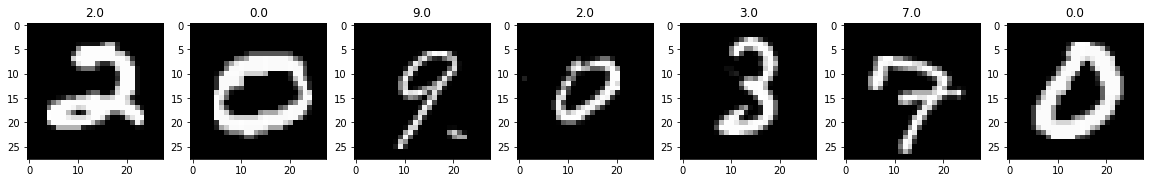

In [59]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:7], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % pred_test[i - 1]);

## Готовим файл для отправки

In [63]:
with open('submit.csv', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(pred_test, 1):
        dst.write('%s,%s\n' % (i, int(p)))

In [66]:
# My submission scored 0.92717